In this notebook, I build classification models to predict whether a bank customer will subscribe to a term deposit (deposit = yes/no) based on their demographic information, financial attributes, and marketing contact details.
This modeling phase builds on the Exploratory Data Analysis (EDA) performed in a separate notebook on the same bank marketing dataset.

Import  libraries needed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I mount Google Drive and load the same bank marketing CSV file used in the EDA notebook into a DataFrame named df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/EDA Project/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Inspect dataset structure

In [5]:
df.shape

(11162, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


### Target variable: `deposit_flag`

For modeling, I created a new binary target variable `deposit_flag`:

- `1` if the customer subscribed to a term deposit (`deposit = "yes"`)
- `0` if the customer did not subscribe (`deposit = "no"`)

This encoding makes the problem a standard binary classification task.  
The class distribution is slightly imbalanced: about **47%** of customers subscribed (1) and **53%** did not subscribe (0).

In [7]:
df['deposit_flag'] = (df['deposit'] == 'yes').astype(int)

### Feature selection

In [8]:
feature_cols = [
    'age', 'balance', 'campaign', 'pdays', 'previous',
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'poutcome'
]

X = df[feature_cols]
y = df['deposit_flag']

In [9]:
X.shape

(11162, 14)

In [10]:
len(y)

11162

### Train–test split

I split the data into training (80%) and test (20%) sets using stratified sampling on the target variable.  
This preserves the original class distribution (subscribed vs not subscribed) in both sets and allows me to evaluate model performance on unseen data.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
print('The shape of X_train is: ', X_train.shape)
print('The shape of X_test is: ', X_test.shape)
print('The shape of y_train is: ', y_train.shape)
print('The shape of y_test is: ', y_test.shape)

The shape of X_train is:  (8929, 14)
The shape of X_test is:  (2233, 14)
The shape of y_train is:  (8929,)
The shape of y_test is:  (2233,)


In [14]:
print('The Value count of y_train is: ', y_train.value_counts(normalize=True))
print('The Value count of y_test is: ', y_test.value_counts(normalize=True))

The Value count of y_train is:  deposit_flag
0    0.526151
1    0.473849
Name: proportion, dtype: float64
The Value count of y_test is:  deposit_flag
0    0.526198
1    0.473802
Name: proportion, dtype: float64


### Preprocessing: numeric and categorical features

For modeling, I will treat numeric and categorical features differently.

- **Numeric features**  
  These are continuous or integer values that can be used directly in the model (optionally scaled):  
  `age`, `balance`, `campaign`, `pdays`, `previous`

- **Categorical features**  
  These are string / category variables that need to be encoded (e.g., one‑hot encoding) before modeling:  
  `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `poutcome`

In the next step, I will build a preprocessing pipeline that leaves numeric features as they are (or scales them) and applies one‑hot encoding to the categorical features before fitting the classification model.

In [15]:
numeric_features = ['age', 'balance', 'campaign', 'pdays', 'previous']

categorical_features = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month', 'poutcome'
]

 Import the preprocessing and model tools

 ColumnTransformer: applies different transformations to different columns (numeric vs categorical).

OneHotEncoder: turns categories into numbers columns.

StandardScaler: scales numeric features (mean 0, std 1); helps some models like logistic regression.

LogisticRegression: our baseline classification model.

Pipeline: chains preprocessing + model into one object so you don’t have to manually transform and then fit.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

 Define the preprocessing steps

In [17]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

 Build the full modeling pipeline

In [18]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

Fit the model on the training data

In [19]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model', LogisticRegression(max_iter=1000))])

Quick evaluation on the test set

In [20]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

print("\nClassification report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.6963725929243171

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1175
           1       0.74      0.56      0.64      1058

    accuracy                           0.70      2233
   macro avg       0.70      0.69      0.69      2233
weighted avg       0.70      0.70      0.69      2233



The logistic regression model achieves about 70% accuracy on the test set. It is better at identifying customers who will not subscribe (recall for class 0 ≈ 82%) than those who will subscribe (recall for class 1 ≈ 56%).
When the model predicts that a customer will subscribe, it is correct in about 74% of cases, but it misses many real subscribers.
As a baseline model, this is a reasonable starting point, but if the business goal is to capture as many potential subscribers as possible, we would need to improve recall for the subscription class

Confusion matrix



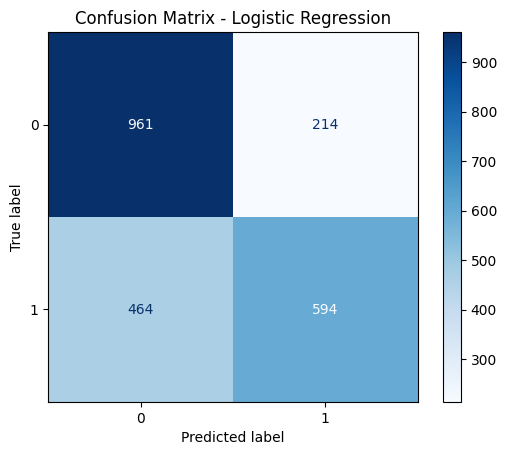

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The confusion matrix shows that the model correctly classifies most non‑subscribers (961 true negatives) and a reasonable number of subscribers (594 true positives). However, it still misses 464 real subscribers (false negatives), which is a large number compared with the 594 it correctly identifies. There are fewer false positives (214).
This means the logistic regression model is better at recognizing customers who will not subscribe than at capturing all potential subscribers. From a marketing point of view, relying only on this model would save some calls (fewer false positives) but would also ignore many customers who might actually subscribe.

## Modeling summary and next steps

In this notebook, I built a baseline classification model to predict term deposit subscription using logistic regression with scaled numeric features and one‑hot encoded categorical features.

Key points:
- The model achieves about **70% accuracy** on the test set.
- It is **better at identifying non‑subscribers** (recall for class 0 ≈ 82%) than subscribers (recall for class 1 ≈ 56%).
- The confusion matrix shows **961 true negatives** and **594 true positives**, but also **464 false negatives**, meaning many potential subscribers are missed.

This baseline model provides a starting point for targeting likely subscribers, but if the business objective is to capture as many potential subscribers as possible, further work is needed, such as:
- Trying more flexible models (e.g., Random Forest or Gradient Boosting).
- Tuning the decision threshold to increase recall for the subscription class.
- Performing model comparison and selecting the best approach for the marketing team.

## Random Forest model – motivation

The logistic regression model provides a simple and interpretable baseline, but it misses many potential subscribers (false negatives).

To check whether we can improve performance, especially recall for customers who subscribe, I now train a **Random Forest** classifier on the same features. Random Forest can capture non‑linear relationships and interactions between variables and often performs better than linear models on complex marketing data.

In [23]:
from sklearn.ensemble import RandomForestClassifier

### Build and train the Random Forest model

In this step, I reuse the same preprocessing pipeline as before  
(scaling numeric features and one‑hot encoding categorical features) and attach a  
`RandomForestClassifier` as the final model inside a scikit‑learn `Pipeline`.

This allows me to train a Random Forest on the fully preprocessed data in one step,  
using the training set (`X_train`, `y_train`), and then evaluate its performance on  
the test set in a consistent way with the logistic regression baseline.

In [26]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100, #Use 100 decision trees in the forest.
        random_state=42
    ))
])

### Train the Random Forest model

Here I fit the Random Forest pipeline on the training data (`X_train`, `y_train`) so it learns the preprocessing steps and the classification model.

In [28]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model', RandomForestClassifier(random_state=42))])

Quick evaluation on the test set

In [29]:
y_hat = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_hat)
print("Test accuracy:", accuracy_rf)

print("\nClassification report:")
print(classification_report(y_test, y_hat))

Test accuracy: 0.7039856695029109

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1175
           1       0.72      0.61      0.66      1058

    accuracy                           0.70      2233
   macro avg       0.71      0.70      0.70      2233
weighted avg       0.71      0.70      0.70      2233



### Random Forest accuracy

The Random Forest model reaches a test accuracy of about **0.70**, which is very similar to the logistic regression baseline (≈0.70).

However, accuracy alone does not show the whole picture. Looking at the class-wise metrics, Random Forest provides **higher recall and F1‑score for the subscription class (1)** than logistic regression, meaning it correctly identifies more customers who actually subscribe, even though overall accuracy stays almost the same.

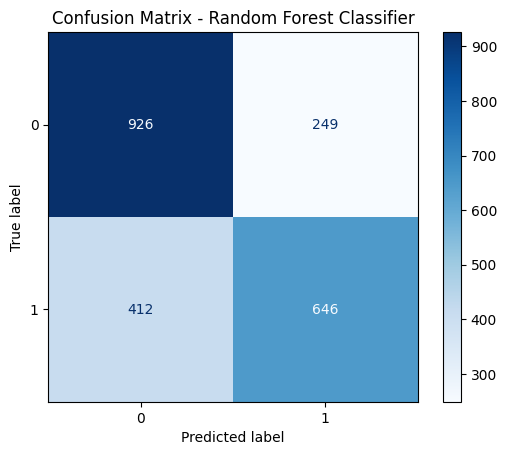

In [32]:
cm_rf = confusion_matrix(y_test, y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### Random Forest confusion matrix interpretation

For the Random Forest model, the confusion matrix shows:

- **926 true negatives** (top-left): customers who did not subscribe and were correctly predicted as "no".
- **646 true positives** (bottom-right): customers who subscribed and were correctly predicted as "yes".
- **249 false positives** (top-right): customers predicted as "yes" but who actually did not subscribe (wasted calls).
- **412 false negatives** (bottom-left): customers predicted as "no" but who actually did subscribe (missed subscribers).

Compared with the logistic regression model (961 TN, 594 TP, 214 FP, 464 FN), the Random Forest:

- **Finds more actual subscribers** (TP increases from 594 to 646) and **misses fewer** (FN drops from 464 to 412).
- Accepts a small increase in **false positives** (from 214 to 249) and a small decrease in true negatives (from 961 to 926).

This confirms that Random Forest is better at identifying potential subscribers (fewer missed opportunities), at the cost of slightly more calls to customers who will not subscribe.

## Modeling summary and recommendation

In this notebook I built and evaluated two models to predict whether a customer will subscribe to a term deposit:

- **Logistic Regression (baseline)**
- **Random Forest Classifier**

Both models used the same features (demographic, financial and campaign information) and the same preprocessing pipeline (scaling numeric features and one‑hot encoding categorical features).

**Logistic Regression**

- Test accuracy: ≈ **0.70**
- Class 1 (subscription): precision ≈ **0.74**, recall ≈ **0.56**, F1 ≈ **0.64**
- Confusion matrix: **594** true positives and **464** false negatives

This model is simple and interpretable, and it is good at recognizing non‑subscribers, but it **misses many actual subscribers**.

**Random Forest**

- Test accuracy: ≈ **0.70**
- Class 1 (subscription): precision ≈ **0.72**, recall ≈ **0.61**, F1 ≈ **0.66**
- Confusion matrix: **646** true positives and **412** false negatives

Compared with logistic regression, the Random Forest model:

- Keeps overall accuracy almost the same
- **Finds more real subscribers** (higher recall and more true positives)
- **Misses fewer subscribers** (fewer false negatives)
- Accepts a small increase in false positives (more customers predicted as “yes” who actually do not subscribe)

### Recommendation

For this marketing problem, the main business goal is to **identify as many potential subscribers as possible**, while keeping the number of wasted calls at a reasonable level.  
Given this objective, I would recommend using the **Random Forest model**, because it achieves similar overall accuracy but provides **better recall and F1‑score for the subscription class**, meaning it captures more subscribing customers and reduces missed opportunities.